In [95]:
import pandas as pd
plt.style.use('fivethirtyeight')
import numpy as np
import matplotlib.pyplot as plt
from evds import evdsAPI
from datetime import date

In [4]:
evds=evdsAPI('dsIC3fiGlu')


In [5]:
usd=evds.get_data(["TP.DK.USD.S.YTL"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
usd.dropna(inplace=True)
usd

,Tarih,TP_DK_USD_S_YTL
0,01-02-2006,1.3263
1,02-02-2006,1.3241
2,03-02-2006,1.3277
3,06-02-2006,1.3257
4,07-02-2006,1.3296
...,...,...
4618,16-10-2023,27.7939
4619,17-10-2023,27.8865
4620,18-10-2023,27.9221
4621,19-10-2023,28.0163


In [6]:
usd['Tarih'] = pd.to_datetime(usd['Tarih'], format='%d-%m-%Y')

# Tarihi indeks olarak ayarla
usd.set_index('Tarih', inplace=True)

# Aylık ortalama değerleri hesapla
usd = usd.resample('M').mean()

# Sonucu görüntüle
usd

,TP_DK_USD_S_YTL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-06-30,23.106042
2023-07-31,26.470338
2023-08-31,26.999127


In [7]:
enf=evds.get_data(["TP.FG.J0"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"))
enf

,Tarih,TP_FG_J0
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
207,2023-5,1300.60
208,2023-6,1351.59
209,2023-7,1479.84
210,2023-8,1614.31


In [8]:

enf=pd.DataFrame(enf)
enf.columns=["Tarih","TÜFE"]


In [9]:


inflation=enf
inflation

,Tarih,TÜFE
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
207,2023-5,1300.60
208,2023-6,1351.59
209,2023-7,1479.84
210,2023-8,1614.31


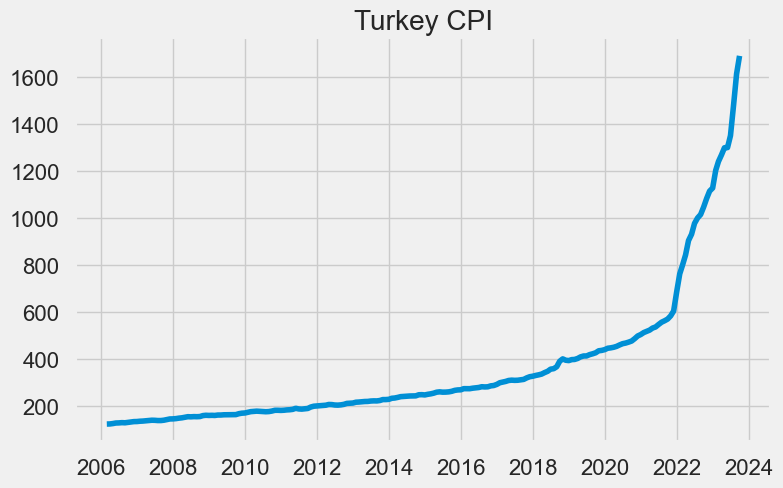

In [100]:
dates=pd.date_range('2006-02-01','2023-10-01' , freq='1M')
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)
plt.figure(figsize=(8,5))
plt.title("Turkey CPI")
plt.plot(df)
plt.show()


In [11]:
df6=pd.DataFrame()
df6["USD/TL"]=usd["TP_DK_USD_S_YTL"]

df6["USD/TL"]=df6["USD/TL"].astype(float)
df6

,USD/TL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-06-30,23.106042
2023-07-31,26.470338
2023-08-31,26.999127


In [12]:
dates= pd.date_range('2006-02-01','2023-11-01' , freq='1M')

            
df6=df6.set_index(dates)

df6["Onceki USD/TL"]=df6["USD/TL"].shift(1)
df6.iloc[0,1]=1.32
df6


,USD/TL,Onceki USD/TL
2006-02-28,1.326535,1.320000
2006-03-31,1.335139,1.326535
2006-04-30,1.337345,1.335139
2006-05-31,1.420659,1.337345
2006-06-30,1.600536,1.420659
...,...,...
2023-06-30,23.106042,19.719514
2023-07-31,26.470338,23.106042
2023-08-31,26.999127,26.470338
2023-09-30,26.989448,26.999127


In [13]:
money=evds.get_data(["TP.PR.ARZ13"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
del money["Tarih"]
money['Tarih'] = pd.to_datetime(money['YEARWEEK'] + '-1', format='%Y-%W-%w')
money = money.groupby(money['Tarih'].dt.to_period('M'))['TP_PR_ARZ13'].mean()
money=pd.DataFrame(money)
money.columns=["Para Arzi"]
money=money/1e+08
money=money.set_index(df6.index)
money

,Para Arzi
2006-02-28,2.424295
2006-03-31,2.473023
2006-04-30,2.514337
2006-05-31,2.648480
2006-06-30,2.794302
...,...
2023-06-30,104.034758
2023-07-31,113.228626
2023-08-31,119.111278
2023-09-30,122.425258


In [14]:
brent=evds.get_data(["TP.BRENTPETROL.EUBP"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=1)
brent

,Tarih,TP_BRENTPETROL_EUBP
0,01-02-2006,65.64
1,02-02-2006,63.49
2,03-02-2006,62.54
3,06-02-2006,63.32
4,07-02-2006,61.64
...,...,...
4610,04-10-2023,89.83
4611,05-10-2023,88.28
4612,06-10-2023,87.86
4613,09-10-2023,91.37


In [15]:
brent['Tarih'] = pd.to_datetime(brent['Tarih'], format='%d-%m-%Y')

# Tarihi indeks olarak ayarla
brent.set_index('Tarih', inplace=True)

# Aylık ortalama değerleri hesapla
brent = brent.resample('M').mean()

# Sonucu görüntüle

brent

,TP_BRENTPETROL_EUBP
Tarih,
2006-02-28,60.210000
2006-03-31,62.064783
2006-04-30,70.260000
2006-05-31,69.776957
2006-06-30,68.555909
...,...
2023-06-30,74.839091
2023-07-31,80.108095
2023-08-31,86.147727


In [16]:
df14=pd.DataFrame()
dates=pd.date_range('2006-02-28','2023-11-29' , freq='1M')

df14["Brent"]=brent["TP_BRENTPETROL_EUBP"]
df14["TIME"]=dates
df14['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df14['TIME'] =  pd.to_datetime(df14['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df14 = df14.set_index(['TIME'])
df14

C:\Users\Bora\AppData\Local\Temp\ipykernel_13960\1303924978.py:7: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df14['TIME'] =  pd.to_datetime(df14['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)


,Brent
TIME,
2006-02-28,60.210000
2006-03-31,62.064783
2006-04-30,70.260000
2006-05-31,69.776957
2006-06-30,68.555909
...,...
2023-06-30,74.839091
2023-07-31,80.108095
2023-08-31,86.147727


In [17]:
kredi=evds.get_data(["TP.KREDI.L001"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
kredi

,Tarih,TP_KREDI_L001
0,2006-2,1.381847e+08
1,2006-3,1.481222e+08
2,2006-4,1.527510e+08
3,2006-5,1.664881e+08
4,2006-6,1.740395e+08
...,...,...
208,2023-6,9.564604e+09
209,2023-7,9.846895e+09
210,2023-8,9.923806e+09
211,2023-9,1.025829e+10


In [18]:
dates=pd.date_range('2006-02-01','2023-11-01' , freq='1M')
kredi=pd.DataFrame(kredi)
kredi.columns=["Tarih","Kredi"]
kredi["Kredi"]=kredi["Kredi"]/1e+08
kredi

,Tarih,Kredi
0,2006-2,1.381847
1,2006-3,1.481222
2,2006-4,1.527510
3,2006-5,1.664881
4,2006-6,1.740395
...,...,...
208,2023-6,95.646045
209,2023-7,98.468952
210,2023-8,99.238055
211,2023-9,102.582870


In [19]:
df3=pd.DataFrame()
df3["Kredi"]=kredi["Kredi"]
df3["TIME"]=dates
df3['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df3['TIME'] =  pd.to_datetime(df3['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df3 = df3.set_index(['TIME'])
df3=df3.set_index(pd.date_range('2006-02-28','2023-11-29' , freq='1M'))
df3

C:\Users\Bora\AppData\Local\Temp\ipykernel_13960\678273782.py:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df3['TIME'] =  pd.to_datetime(df3['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)


,Kredi
2006-02-28,1.381847
2006-03-31,1.481222
2006-04-30,1.527510
2006-05-31,1.664881
2006-06-30,1.740395
...,...
2023-06-30,95.646045
2023-07-31,98.468952
2023-08-31,99.238055
2023-09-30,102.582870


In [102]:
pfaiz=evds.get_data(["TP.APIFON4"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
pfaiz.columns=["Tarih","Faiz"]
pfaiz.iloc[:11,1]=17.5
pfaiz.iloc[11:23,1]=21.5
pfaiz.iloc[23:35,1]=19.25
pfaiz.iloc[35:47,1]=10.25
pfaiz.iloc[47:59,1]=8
pfaiz["Faiz"]=pfaiz["Faiz"].astype(float)
pfaiz.iloc[212,1]=35
pfaiz



,Tarih,Faiz
0,2006-2,17.50
1,2006-3,17.50
2,2006-4,17.50
3,2006-5,17.50
4,2006-6,17.50
...,...,...
208,2023-6,12.84
209,2023-7,17.50
210,2023-8,23.50
211,2023-9,31.00


In [103]:
dates=pd.date_range('2006-02-28','2023-11-29' , freq='1M')
pfaiz=pd.DataFrame(pfaiz)
pfaiz.columns=["Tarih","Politika Faizi"]
pfaiz["TIME"]=dates
pfaiz['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
pfaiz['TIME'] =  pd.to_datetime(pfaiz['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
pfaiz = pfaiz.set_index(['TIME'])
del pfaiz["Tarih"]
pfaiz

,Politika Faizi
TIME,
2006-02-28,17.50
2006-03-31,17.50
2006-04-30,17.50
2006-05-31,17.50
2006-06-30,17.50
...,...
2023-06-30,12.84
2023-07-31,17.50
2023-08-31,23.50


In [22]:
kfaiz=evds.get_data(["TP.KTFTUK"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
kfaiz.columns=["Tarih","Kredi Faizi"]
kfaiz=kfaiz.set_index(kfaiz["Tarih"])
del kfaiz["Tarih"]
kfaiz=kfaiz.astype(float)
kfaiz=kfaiz.set_index(pd.date_range('2006-02-28','2023-11-29' , freq='1M'))
kfaiz

,Kredi Faizi
2006-02-28,17.2975
2006-03-31,17.0080
2006-04-30,16.2075
2006-05-31,16.3000
2006-06-30,19.6700
...,...
2023-06-30,38.5600
2023-07-31,45.8250
2023-08-31,45.7650
2023-09-30,56.2980


In [104]:
perakende=pd.read_excel("C:/Users/Bora/Downloads/perakende satis hacim endeksi ve degisim oranlari (sabit fiyatlarla) (2015=100).xls")
perakende1=perakende.iloc[5:,2].dropna(axis=0).astype(float)
perakende1=pd.DataFrame(perakende1)
perakende1.columns=["Arındırılmamış"]


perakende1["Takvimden Arındırılmış"]=perakende.iloc[5:169,4].astype(float)
perakende1["Mevsimsellikten ve Takvimden Arındırılmış"]=perakende.iloc[5:169,7].astype(float)
perakende1=perakende1.set_index(pd.date_range(start="2010-01-01",end="2023-09-01",freq="1M"))
perakende1






,Arındırılmamış,Takvimden Arındırılmış,Mevsimsellikten ve Takvimden Arındırılmış
2010-01-31,57.403841,57.747949,67.560585
2010-02-28,57.317027,57.179176,68.192727
2010-03-31,67.904361,67.034985,69.536955
2010-04-30,67.048510,66.458455,70.175625
2010-05-31,70.327428,70.614865,70.604236
...,...,...,...
2023-04-30,165.916139,169.886079,174.404111
2023-05-31,181.176925,179.726145,180.185729
2023-06-30,180.070938,186.141640,180.131292
2023-07-31,191.355951,193.831190,185.482059


In [24]:
motorin=pd.read_excel("C:/Users/Bora/Downloads/motorin.xlsx")
motorin.columns=["Tarih","Motorin"]
motorin=motorin.set_index(pd.date_range(start="2003-01-01",end="2023-10-01",freq="1M"))
del motorin["Tarih"]
motorin=motorin.astype(float)
motorin

,Motorin
2003-01-31,1.366645
2003-02-28,1.457199
2003-03-31,1.529555
2003-04-30,1.439813
2003-05-31,1.404363
...,...
2023-05-31,18.920000
2023-06-30,22.100000
2023-07-31,29.480000
2023-08-31,37.370000


In [25]:
sanayi=evds.get_data(["TP.SANAYREV4.Y1"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
sanayi=sanayi.set_index(pd.date_range(start="2006-02-01",end="2023-09-01",freq="1M"))
del sanayi["Tarih"]
sanayi.columns=["Sanayi"]
sanayi

,Sanayi
2006-02-28,55.819129
2006-03-31,65.933232
2006-04-30,62.501869
2006-05-31,66.499838
2006-06-30,67.519860
...,...
2023-04-30,129.873251
2023-05-31,149.379361
2023-06-30,137.891848
2023-07-31,145.483816


In [26]:
mfaiz=evds.get_data(["TP.TRY.MT02"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
mfaiz=mfaiz.set_index(pd.date_range(start="2006-02-01",end="2023-11-01",freq="1M"))
del mfaiz["Tarih"]
mfaiz.columns=["Mevduat Faizi"]
mfaiz

,Mevduat Faizi
2006-02-28,15.7600
2006-03-31,15.3300
2006-04-30,15.1750
2006-05-31,14.9250
2006-06-30,15.5840
...,...
2023-06-30,39.5920
2023-07-31,33.1250
2023-08-31,29.4125
2023-09-30,41.6560


In [27]:
from datetime import date
enf_belirsizlik=evds.get_data(["TP.BEK.S01.E.S"],startdate="30-06-2013",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
enf_belirsizlik=enf_belirsizlik.set_index(pd.date_range(start="2013-06-30",end="2023-11-29",freq="1M"))
del enf_belirsizlik["Tarih"]
enf_belirsizlik.columns=["Enflasyon Belirsizliği"]
enf_belirsizlik

,Enflasyon Belirsizliği
2013-06-30,0.62
2013-07-31,0.74
2013-08-31,0.74
2013-09-30,0.77
2013-10-31,0.65
...,...
2023-06-30,7.55
2023-07-31,7.70
2023-08-31,6.81
2023-09-30,7.30


In [28]:
borc=evds.get_data(["TP.KB.A09"],startdate="28-02-2010",enddate="30-10-2023",frequency=5)
del borc["Tarih"]
borc=borc.set_index(pd.date_range(start="2010-02-28",end="2023-09-29",freq="1M"))
borc.columns=["Borç"]
borc

,Borç
2010-02-28,3.394344e+08
2010-03-31,3.406784e+08
2010-04-30,3.431629e+08
2010-05-31,3.405206e+08
2010-06-30,3.431419e+08
...,...
2023-04-30,2.292927e+09
2023-05-31,2.348115e+09
2023-06-30,2.575631e+09
2023-07-31,2.643068e+09


In [29]:
data=pd.DataFrame()
data["USDTL"]=df6["USD/TL"].rolling(3).mean()
data["ParaArzi"]=money["Para Arzi"].shift(1)
data["Motorin"]=motorin["Motorin"]
data["Perakende Satış"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"]
data["Sanayi"]=sanayi["Sanayi"]
data["Borç"]=borc["Borç"].shift(1)
data["Kredi"]=df3["Kredi"].rolling(2).mean()
data["TÜFE"]=df["CPI"]
data=data.pct_change(periods=1)*100
data=data.head(211)
#data["Shock"]=0
#data.iloc[-1,8]=1.0
#data.iloc[-2,8]=1.0
data=data.dropna(axis=0)
#data["MevduatFaizi"]=mfaiz["Mevduat Faizi"]

data

C:\Users\Bora\AppData\Local\Temp\ipykernel_13960\2133083838.py:10: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  data=data.pct_change(periods=1)*100


,USDTL,ParaArzi,Motorin,Perakende Satış,Sanayi,Borç,Kredi,TÜFE
2010-04-30,0.478728,2.045229,0.713406,0.918462,-2.890475,0.366513,3.033220,0.596780
2010-05-31,0.646630,1.135924,-0.856462,0.610769,4.442741,0.729264,3.592510,-0.358182
2010-06-30,0.922501,0.955408,-0.175370,-0.094972,4.517071,-0.769974,3.358199,-0.561672
2010-07-31,1.054885,2.107244,-1.581105,1.974389,0.720416,0.769773,3.257982,-0.480117
2010-08-31,-0.714734,2.007924,1.520561,1.144214,-3.644655,0.587551,2.661164,0.402974
...,...,...,...,...,...,...,...,...
2023-04-30,0.963176,3.880167,-1.492537,0.772387,-14.132513,10.507274,5.406548,2.385509
2023-05-31,1.507585,4.857908,-7.526882,3.315070,15.019343,2.663712,3.535416,0.043076
2023-06-30,7.066073,0.788974,16.807611,-0.030212,-7.690161,2.406884,5.711697,3.920498
2023-07-31,11.475241,9.567224,33.393665,2.970482,5.505741,9.689321,5.675617,9.488824


In [30]:

data["Enflasyon Belirsizliği"]=enf_belirsizlik
data["Kredi Faizi"]=kfaiz["Kredi Faizi"]
data["Mevduat Faizi"]=mfaiz["Mevduat Faizi"]
data["Zam"]=0
data["Politika Faizi"]=pfaiz["Politika Faizi"]
data=data.dropna(axis=0)
data=data[['USDTL', 'Motorin', 'Perakende Satış', 'Kredi Faizi','Zam', 'Sanayi', 'Enflasyon Belirsizliği','ParaArzi','Borç','Kredi','Mevduat Faizi','Politika Faizi',"TÜFE"]]
data.iloc[7,4]=11.01
data.iloc[19,4]=12.3
data.iloc[31,4]=29.32
data.iloc[43,4]=7.92
data.iloc[55,4]=14.17
data.iloc[67,4]=25.45
data.iloc[79,4]=15
data.iloc[91,4]=26.56
data.iloc[103,4]=50
data.iloc[109,4]=29.31
data.iloc[115,4]=54.66
data.iloc[121,4]=34
data.iloc[120:,11]=[15,17.5,25]
data

C:\Users\Bora\AppData\Local\Temp\ipykernel_13960\3197375848.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '11.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.iloc[7,4]=11.01


,USDTL,Motorin,Perakende Satış,Kredi Faizi,Zam,Sanayi,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,Politika Faizi,TÜFE
2013-06-30,1.608806,2.388347,0.317048,9.9950,0.0,-0.719400,0.62,1.640855,0.398263,4.506935,6.8000,5.11,0.763393
2013-07-31,2.430904,2.487831,-0.866441,10.9200,0.0,2.713011,0.74,2.646003,0.170717,2.215850,7.7375,6.44,0.311161
2013-08-31,2.336032,0.775496,2.611863,11.8260,0.0,-17.189911,0.74,1.746407,1.296896,2.497005,8.3520,6.62,-0.103399
2013-09-30,2.122082,3.333106,-0.400995,12.7450,0.0,24.131580,0.77,2.481161,0.853359,3.104101,8.7700,6.45,0.765042
2013-10-31,1.013333,-1.751603,1.029442,12.8900,0.0,-8.904150,0.65,2.686764,0.881470,1.070377,8.4750,6.27,1.799830
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-30,0.963176,-1.492537,0.772387,29.2275,0.0,-14.132513,7.51,3.880167,10.507274,5.406548,28.3425,8.70,2.385509
2023-05-31,1.507585,-7.526882,3.315070,32.0225,0.0,15.019343,7.37,4.857908,2.663712,3.535416,31.4625,9.09,0.043076
2023-06-30,7.066073,16.807611,-0.030212,38.5600,0.0,-7.690161,7.55,0.788974,2.406884,5.711697,39.5920,15.00,3.920498
2023-07-31,11.475241,33.393665,2.970482,45.8250,34.0,5.505741,7.70,9.567224,9.689321,5.675617,33.1250,17.50,9.488824


<Axes: >

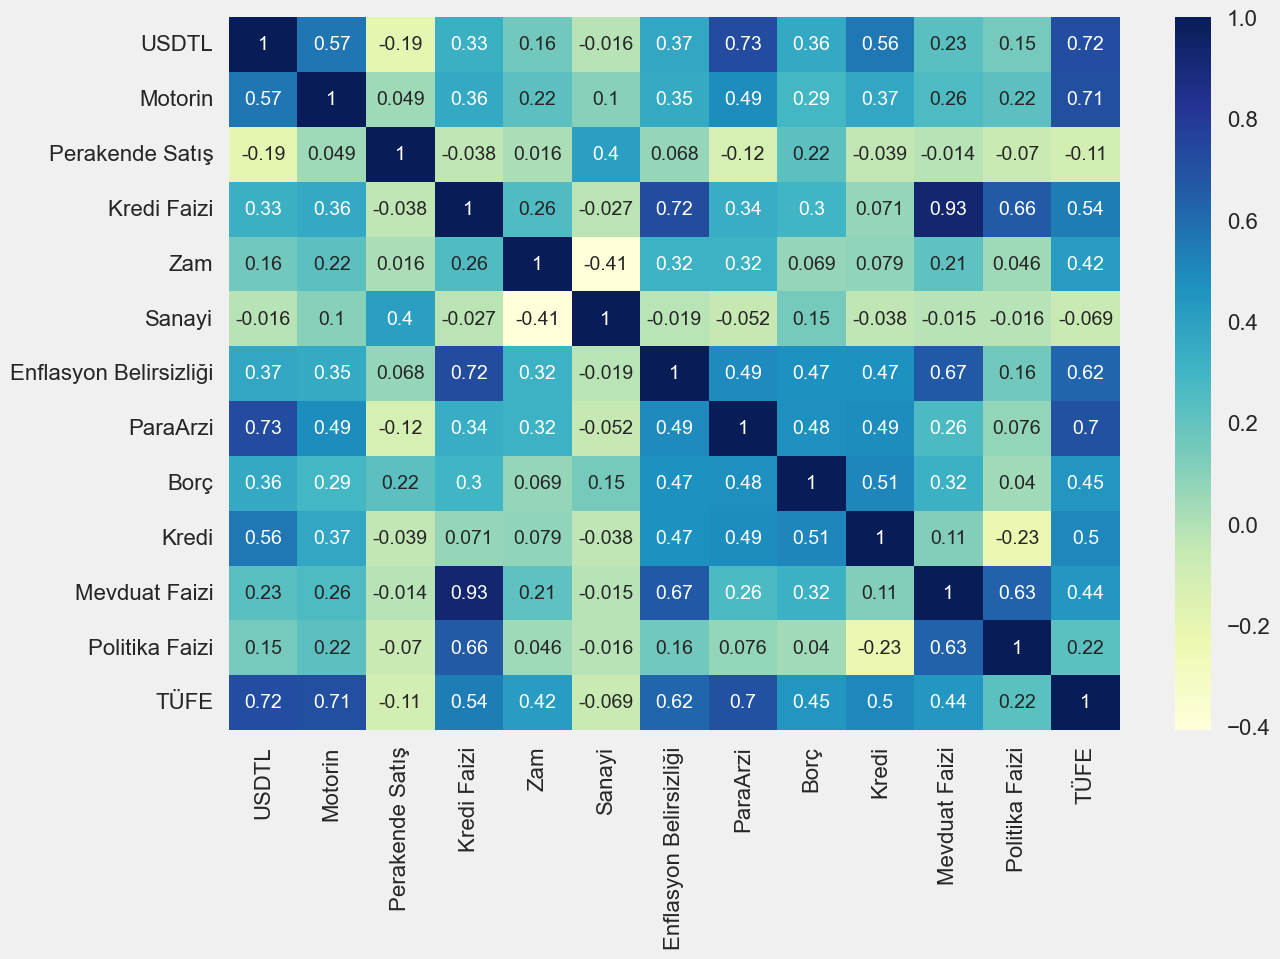

In [105]:
import seaborn as sns
sns.heatmap(data.corr(),cmap="YlGnBu", annot=True)

In [32]:
from itertools import combinations
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
best_mse = float("inf")
features=['USDTL', 'Motorin', 'Perakende Satış', 'Kredi Faizi','Zam', 'Sanayi',
       'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi','Politika Faizi']
# En iyi özellik kümesi
best_features = []

# Veriyi eğitim ve test setlerine ayırın
X = data[features]
X_train=X.iloc[:-9,:]
X_test=X.iloc[-9:,:]
y=data["TÜFE"]
y_train=y[:-9]
y_test=y[-9:]

# 2-7 özellikler arasındaki kombinasyonları dene
for r in range(2, 13):
    for combo in combinations(features, r):
        selected_features = list(combo)
        X_train_subset = X_train[selected_features]
        X_test_subset = X_test[selected_features]
        
        # MLP Regressor modelini oluşturun ve eğitin
        model=sm.OLS(y_train,X_train_subset).fit()
        
        
        # Modeli kullanarak tahmin yapın
        y_pred = model.predict(X_test_subset)
        
        # Ortalama kare hata (MSE) hesaplayın
        rmse1 = np.sqrt(mean_squared_error(y_test, y_pred))
        
        # En iyi MSE değerini ve özellik kombinasyonunu güncelleyin
        if rmse1 < best_mse:
            best_mse = rmse1
            best_features = selected_features

# En iyi özellik kombinasyonu ve MSE değeri
print("En iyi özellik kombinasyonu:")
print(best_features)
print("En iyi MSE değeri:", best_mse)

En iyi özellik kombinasyonu:
['Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'Politika Faizi']
En iyi MSE değeri: 1.0115892225284857


In [282]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'Politika Faizi']
X = data[features]
X_train=X.iloc[:-9,:]
X_test=X.iloc[-9:,:]
y=data["TÜFE"]
y_train=y[:-9]
y_test=y[-9:]
model=sm.OLS(y_train,X_train).fit()

        

rmse=[]
tahminler=pd.DataFrame()
tahminler["Aylık Enflasyon"]=y_test
tahminler["Linear Regression"]=model.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Linear Regression"])))


In [283]:
from itertools import combinations
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
warnings.filterwarnings("ignore")
best_mse = float("inf")
features=['USDTL', 'Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Sanayi',
       'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi','Politika Faizi']
# En iyi özellik kümesi
best_features = []

# Veriyi eğitim ve test setlerine ayırın
X = data[features]
X_train=X.iloc[:-9,:]
X_test=X.iloc[-9:,:]
y_train=y[:-9]
y_test=y[-9:]

# 2-7 özellikler arasındaki kombinasyonları dene
for r in range(2, 13):
    for combo in combinations(features, r):
        selected_features = list(combo)
        X_train_subset = X_train[selected_features]
        X_test_subset = X_test[selected_features]
        
        # MLP Regressor modelini oluşturun ve eğitin
        reg = linear_model.BayesianRidge()
        reg.fit(X_train_subset, y_train)
        
        
        # Modeli kullanarak tahmin yapın
        y_pred = reg.predict(X_test_subset)
        
        # Ortalama kare hata (MSE) hesaplayın
        rmse1 = np.sqrt(mean_squared_error(y_test, y_pred))
        
        # En iyi MSE değerini ve özellik kombinasyonunu güncelleyin
        if rmse1 < best_mse:
            best_mse = rmse1
            best_features = selected_features

# En iyi özellik kombinasyonu ve MSE değeri
print("En iyi özellik kombinasyonu:")
print(best_features)
print("En iyi MSE değeri:", best_mse)

En iyi özellik kombinasyonu:
['Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği']
En iyi MSE değeri: 1.0700937300521691


In [284]:
from sklearn import linear_model
from sklearn.metrics import  mean_squared_error
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği']
X = data[features]
X_train=X.iloc[:-9,:]
X_test=X.iloc[-9:,:]
y=data["TÜFE"]
y_train=y[:-9]
y_test=y[-9:]
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)

tahminler["Bayesian Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Bayesian Regression"])))


In [36]:
from itertools import combinations
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
best_mse = float("inf")
features=['USDTL', 'Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Sanayi',
       'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi','Politika Faizi']
# En iyi özellik kümesi
best_features = []

# Veriyi eğitim ve test setlerine ayırın
X = data[features]
X_train=X.iloc[:-9,:]
X_test=X.iloc[-9:,:]
y_train=y[:-9]
y_test=y[-9:]

# 2-7 özellikler arasındaki kombinasyonları dene
for r in range(2, 13):
    for combo in combinations(features, r):
        selected_features = list(combo)
        X_train_subset = X_train[selected_features]
        X_test_subset = X_test[selected_features]
        
        # MLP Regressor modelini oluşturun ve eğitin
        
        reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3))
        reg.fit(X_train_subset, y_train)
        
        # Modeli kullanarak tahmin yapın
        y_pred = reg.predict(X_test_subset)
        
        # Ortalama kare hata (MSE) hesaplayın
        rmse1 = np.sqrt(mean_squared_error(y_test, y_pred))
        
        # En iyi MSE değerini ve özellik kombinasyonunu güncelleyin
        if rmse1 < best_mse:
            best_mse = rmse1
            best_features = selected_features

# En iyi özellik kombinasyonu ve MSE değeri
print("En iyi özellik kombinasyonu:")
print(best_features)
print("En iyi MSE değeri:", best_mse)

En iyi özellik kombinasyonu:
['Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'Politika Faizi']
En iyi MSE değeri: 1.0371431249115262


In [37]:
from itertools import combinations
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
best_mse = float("inf")
features=['USDTL', 'Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Sanayi',
       'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi','Politika Faizi']
# En iyi özellik kümesi
best_features = []

# Veriyi eğitim ve test setlerine ayırın
X = data[features]
X_train=X.iloc[:-9,:]
X_test=X.iloc[-9:,:]
y_train=y[:-9]
y_test=y[-9:]

# 2-7 özellikler arasındaki kombinasyonları dene
for r in range(2, 13):
    for combo in combinations(features, r):
        selected_features = list(combo)
        X_train_subset = X_train[selected_features]
        X_test_subset = X_test[selected_features]
        
        # MLP Regressor modelini oluşturun ve eğitin
        
        reg = linear_model.Lasso(alpha=0.1)
        reg.fit(X_train_subset,y_train)
        
        # Modeli kullanarak tahmin yapın
        y_pred = reg.predict(X_test_subset)
        
        # Ortalama kare hata (MSE) hesaplayın
        rmse1 = np.sqrt(mean_squared_error(y_test, y_pred))
        
        # En iyi MSE değerini ve özellik kombinasyonunu güncelleyin
        if rmse1 < best_mse:
            best_mse = rmse1
            best_features = selected_features

# En iyi özellik kombinasyonu ve MSE değeri
print("En iyi özellik kombinasyonu:")
print(best_features)
print("En iyi MSE değeri:", best_mse)

En iyi özellik kombinasyonu:
['Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği']
En iyi MSE değeri: 1.0712037153868021


In [285]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği']
X = data[features]
X_train=X.iloc[:-9,:]
X_test=X.iloc[-9:,:]
y=data["TÜFE"]
y_train=y[:-9]
y_test=y[-9:]

reg = linear_model.Lasso(alpha=0.1)
reg.fit(X_train,y_train)

tahminler["Lasso Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Lasso Regression"])))

In [286]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'Politika Faizi']
X = data[features]
X_train=X.iloc[:-9,:]
X_test=X.iloc[-9:,:]
y=data["TÜFE"]
y_train=y[:-9]
y_test=y[-9:]
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(X_train, y_train)

tahminler["SGD Regressor"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["SGD Regressor"])))

In [40]:
from itertools import combinations
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
best_mse = float("inf")
features=['USDTL', 'Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Sanayi',
       'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi','Politika Faizi']
# En iyi özellik kümesi
best_features = []

# Veriyi eğitim ve test setlerine ayırın
X = data[features]
X_train=X.iloc[:-9,:]
X_test=X.iloc[-9:,:]
y_train=y[:-9]
y_test=y[-9:]

# 2-7 özellikler arasındaki kombinasyonları dene
for r in range(2, 13):
    for combo in combinations(features, r):
        selected_features = list(combo)
        X_train_subset = X_train[selected_features]
        X_test_subset = X_test[selected_features]
        
        # MLP Regressor modelini oluşturun ve eğitin
        
        reg = linear_model.Lars(random_state=0)
        reg.fit(X_train_subset,y_train)
        
        # Modeli kullanarak tahmin yapın
        y_pred = reg.predict(X_test_subset)
        
        # Ortalama kare hata (MSE) hesaplayın
        rmse1 = np.sqrt(mean_squared_error(y_test, y_pred))
        
        # En iyi MSE değerini ve özellik kombinasyonunu güncelleyin
        if rmse1 < best_mse:
            best_mse = rmse1
            best_features = selected_features

# En iyi özellik kombinasyonu ve MSE değeri
print("En iyi özellik kombinasyonu:")
print(best_features)
print("En iyi MSE değeri:", best_mse)

En iyi özellik kombinasyonu:
['Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'Politika Faizi']
En iyi MSE değeri: 0.9999108275836147


In [287]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'Politika Faizi']
X = data[features]
X_train=X.iloc[:-9,:]
X_test=X.iloc[-9:,:]
y=data["TÜFE"]
y_train=y[:-9]
y_test=y[-9:]
reg = linear_model.Lars(random_state=0)
reg.fit(X_train,y_train)

tahminler["Lars Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Lars Regression"])))

In [288]:
warnings.filterwarnings("ignore")
features=['USDTL', 'Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Kredi', 'Mevduat Faizi']
X = data[features]
X_train=X.iloc[:-9,:]
X_test=X.iloc[-9:,:]
y_train=y[:-9]
y_test=y[-9:]
model = MLPRegressor(random_state=1, max_iter=500000)
model.fit(X_train, y_train)
        



tahminler["MLP Regression"]=model.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["MLP Regression"])))


In [43]:
from itertools import combinations
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.kernel_ridge import KernelRidge
warnings.filterwarnings("ignore")
best_mse = float("inf")
features=['USDTL', 'Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Sanayi',
       'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi','Politika Faizi']
# En iyi özellik kümesi
best_features = []

# Veriyi eğitim ve test setlerine ayırın
X = data[features]
X_train=X.iloc[:-9,:]
X_test=X.iloc[-9:,:]
y_train=y[:-9]
y_test=y[-9:]

# 2-7 özellikler arasındaki kombinasyonları dene
for r in range(2, 13):
    for combo in combinations(features, r):
        selected_features = list(combo)
        X_train_subset = X_train[selected_features]
        X_test_subset = X_test[selected_features]
        
        # MLP Regressor modelini oluşturun ve eğitin
        
        kernel = DotProduct() + WhiteKernel()
        gpr = GaussianProcessRegressor(kernel=kernel,
        random_state=0).fit(X_train_subset, y_train) 
        
        # Modeli kullanarak tahmin yapın
        y_pred = gpr.predict(X_test_subset)
        
        # Ortalama kare hata (MSE) hesaplayın
        rmse1 = np.sqrt(mean_squared_error(y_test, y_pred))
        
        # En iyi MSE değerini ve özellik kombinasyonunu güncelleyin
        if rmse1 < best_mse:
            best_mse = rmse1
            best_features = selected_features

# En iyi özellik kombinasyonu ve MSE değeri
print("En iyi özellik kombinasyonu:")
print(best_features)
print("En iyi MSE değeri:", best_mse)

En iyi özellik kombinasyonu:
['Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'Politika Faizi']
En iyi MSE değeri: 1.0213610592177629


In [289]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.kernel_ridge import KernelRidge
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'Politika Faizi']
X = data[features]
X_train=X.iloc[:-9,:]
X_test=X.iloc[-9:,:]
y_train=y[:-9]
y_test=y[-9:]
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel,
  random_state=0).fit(X_train, y_train) 
        

        



tahminler["Gaussian Regression"]=gpr.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Gaussian Regression"])))



In [45]:
from itertools import combinations
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.kernel_ridge import KernelRidge
warnings.filterwarnings("ignore")
best_mse = float("inf")
features=['USDTL', 'Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Sanayi',
       'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi','Politika Faizi']
# En iyi özellik kümesi
best_features = []

# Veriyi eğitim ve test setlerine ayırın
X = data[features]
X_train=X.iloc[:-9,:]
X_test=X.iloc[-9:,:]
y_train=y[:-9]
y_test=y[-9:]

# 2-7 özellikler arasındaki kombinasyonları dene
for r in range(2, 13):
    for combo in combinations(features, r):
        selected_features = list(combo)
        X_train_subset = X_train[selected_features]
        X_test_subset = X_test[selected_features]
        
        # MLP Regressor modelini oluşturun ve eğitin
        
        krr = KernelRidge(alpha=1.0)
        krr.fit(X_train_subset, y_train)
        
        # Modeli kullanarak tahmin yapın
        y_pred = krr.predict(X_test_subset)
        
        # Ortalama kare hata (MSE) hesaplayın
        rmse1 = np.sqrt(mean_squared_error(y_test, y_pred))
        
        # En iyi MSE değerini ve özellik kombinasyonunu güncelleyin
        if rmse1 < best_mse:
            best_mse = rmse1
            best_features = selected_features

# En iyi özellik kombinasyonu ve MSE değeri
print("En iyi özellik kombinasyonu:")
print(best_features)
print("En iyi MSE değeri:", best_mse)

En iyi özellik kombinasyonu:
['Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'Politika Faizi']
En iyi MSE değeri: 1.0122178659418324


In [290]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.kernel_ridge import KernelRidge
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'Politika Faizi']
X = data[features]
X_train=X.iloc[:-9,:]
X_test=X.iloc[-9:,:]
y_train=y[:-9]
y_test=y[-9:]
krr = KernelRidge(alpha=1.0)
krr.fit(X_train, y_train)
        

        



tahminler["Kernel Regression"]=krr.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Kernel Regression"])))



In [291]:
from itertools import combinations
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import  KerasRegressor
from keras.optimizers import Adam
import tensorflow as tf
from keras.layers import Dense
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Sanayi', 'ParaArzi', 'Borç', 'Mevduat Faizi']
X = data[features]
X_train=X.iloc[:-9,:]
X_test=X.iloc[-9:,:]
y_train=y[:-9]
y_test=y[-9:]
model = tf.keras.models.Sequential()
model.add(Dense(units=64,input_dim=X_train.shape[1],activation="linear"))
model.add(Dense(32,activation="linear"))
model.add(Dense(16,activation="linear"))
model.add(Dense(1,activation="linear"))
model.compile(optimizer=Adam(learning_rate=0.01),loss="mae",metrics=["mae"])
cıktı=model.fit(X_train,y_train,epochs=100,verbose=0)
        



tahminler["DNN"]=model.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["DNN"])))

1/1 [==============================] - 0s 63ms/step


In [292]:
rmse_df=pd.DataFrame(rmse,index=[tahminler.columns[1:]])
rmse_df.columns=["RMSE"]
rmse_df=rmse_df.sort_values(by="RMSE")
rmse_df

,RMSE
Lars Regression,0.999911
Linear Regression,1.011589
Kernel Regression,1.012218
Gaussian Regression,1.021361
MLP Regression,1.030412
SGD Regressor,1.044547
Bayesian Regression,1.070094
Lasso Regression,1.071204
DNN,1.329330


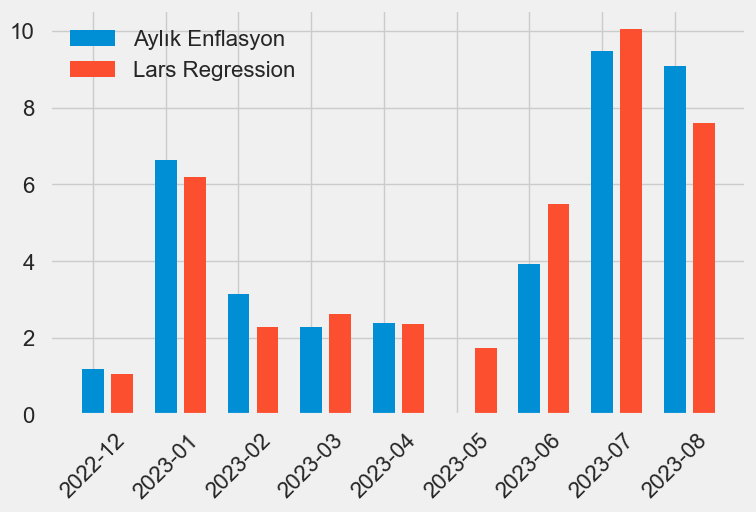

In [293]:
X_axis = np.arange(len(tahminler))
plt.figure(figsize=(8,5)) 
plt.bar(X_axis,tahminler["Aylık Enflasyon"],width=0.3,label="Aylık Enflasyon")
#plt.bar(X_axis+0.2,tahminler["Linear Regression"],width=0.3,label="Linear Regression")
plt.bar(X_axis+0.4,tahminler["Lars Regression"],width=0.3,label="Lars Regression")
plt.xticks(X_axis,tahminler.index.strftime("%Y-%m"),rotation=45)
plt.legend()

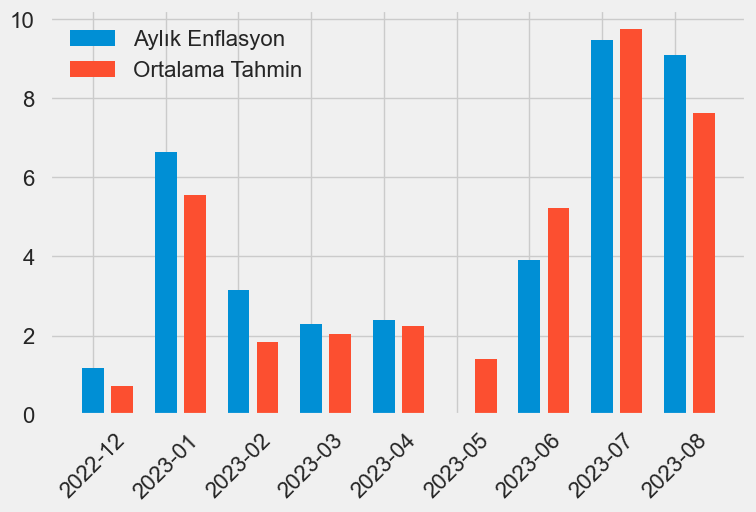

In [294]:
tahminler["Ortalama"]=tahminler.iloc[:,1:].mean(axis=1)
X_axis = np.arange(len(tahminler)) 
plt.figure(figsize=(8,5)) 
plt.bar(X_axis,tahminler["Aylık Enflasyon"],width=0.3,label="Aylık Enflasyon")
plt.bar(X_axis+0.4,tahminler["Ortalama"],width=0.3,label="Ortalama Tahmin")
plt.xticks(X_axis,tahminler.index.strftime("%Y-%m"),rotation=45)
plt.legend()

In [51]:
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt

# Veriyi yükleyin veya veriyi oluşturun
# Örneğin, 'veri.csv' adlı bir CSV dosyasından veriyi yükleyin


# Modelin parametre kombinasyonlarını tanımlayın
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

best_rmse = float("inf")
best_params = None

# En iyi modeli seçin
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(sanayi["Sanayi"].iloc[:-12],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()

            # Tahminleri yapın
            pred = results.get_forecast(steps=12)
            forecasted = pred.predicted_mean

            # RMSE hesaplayın
            rmse = sqrt(mean_squared_error(sanayi['Sanayi'].iloc[-12:], forecasted))

            # En iyi RMSE'yi ve parametreleri güncelleyin
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = (param, param_seasonal)

        except:
            continue

print("En iyi parametreler:", best_params)
print("En iyi RMSE:", best_rmse)


En iyi parametreler: ((0, 0, 0), (1, 0, 1, 12))
En iyi RMSE: 6.280256751249998


In [166]:
from statsmodels.tsa.ar_model import AutoReg
import statsmodels as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.api import VAR
import warnings



import pmdarima as pm

from pmdarima.arima import auto_arima



model = SARIMAX(sanayi["Sanayi"], order=(0, 0, 0), seasonal_order=(1, 0, 1, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 16 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)

# Tahmin edilen değerleri alın
forecast_values = pd.DataFrame(forecast.predicted_mean)
forecast_values.columns=["Sanayi"]

sanayitahmin=pd.concat([forecast_values],axis=0)
sanayitahmin=sanayitahmin.dropna(axis=0)

row=pd.DataFrame({"Sanayi":sanayi.iloc[210,0]},index=pd.date_range(start="2023-08-30",end="2023-09-29",freq="1M"))
sanayitahmin=pd.concat([row,sanayitahmin],axis=0)
sanayitahmin




,Sanayi
2023-08-31,149.233670
2023-09-30,145.946921
2023-10-31,147.303447
2023-11-30,147.965523
2023-12-31,162.075359
2024-01-31,136.439229
2024-02-29,121.134762
2024-03-31,150.344072
2024-04-30,127.461565
2024-05-31,150.240657


In [53]:
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt

# Veriyi yükleyin veya veriyi oluşturun
# Örneğin, 'veri.csv' adlı bir CSV dosyasından veriyi yükleyin


# Modelin parametre kombinasyonlarını tanımlayın
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

best_rmse = float("inf")
best_params = None

# En iyi modeli seçin
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(perakende1["Mevsimsellikten ve Takvimden Arındırılmış"].iloc[:-12],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()

            # Tahminleri yapın
            pred = results.get_forecast(steps=12)
            forecasted = pred.predicted_mean

            # RMSE hesaplayın
            rmse = sqrt(mean_squared_error(perakende1['Mevsimsellikten ve Takvimden Arındırılmış'].iloc[-12:], forecasted))

            # En iyi RMSE'yi ve parametreleri güncelleyin
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = (param, param_seasonal)

        except:
            continue

print("En iyi parametreler:", best_params)
print("En iyi RMSE:", best_rmse)


En iyi parametreler: ((1, 0, 1), (0, 0, 0, 12))
En iyi RMSE: 14.042042793236474


In [167]:
from statsmodels.tsa.ar_model import AutoReg
import statsmodels as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.api import VAR
import warnings



import pmdarima as pm

from pmdarima.arima import auto_arima



model = SARIMAX(perakende1["Mevsimsellikten ve Takvimden Arındırılmış"], order=(1, 0, 1), seasonal_order=(0, 0, 0, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 16 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)

# Tahmin edilen değerleri alın
forecast_values = pd.DataFrame(forecast.predicted_mean)
forecast_values.columns=["Perakende"]

perakendetahmin=pd.concat([forecast_values],axis=0)
perakendetahmin=perakendetahmin.dropna(axis=0)
perakendetahmin




,Perakende
2023-09-30,175.861239
2023-10-31,175.752870
2023-11-30,175.644568
2023-12-31,175.536333
2024-01-31,175.428164
2024-02-29,175.320062
2024-03-31,175.212026
2024-04-30,175.104057
2024-05-31,174.996155
2024-06-30,174.888319


In [274]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMA

ar_model = AutoReg(df6['USD/TL'], lags=2)
ar_fit = ar_model.fit()
usdtahmin = ar_fit.predict(start="2023-11-30", end="2024-12-30", dynamic=False)
usdtahmin=pd.DataFrame(usdtahmin)
usdtahmin.columns=["USD/TL"]
row=pd.DataFrame({"USD/TL":df6["USD/TL"].iloc[-5:]},index=pd.date_range(start="2023-06-30",end="2023-11-29",freq="1M"))
usdtahmin=pd.concat([row,usdtahmin],axis=0)
usdtahmin

,USD/TL
2023-06-30,23.106042
2023-07-31,26.470338
2023-08-31,26.999127
2023-09-30,26.989448
2023-10-31,27.714100
2023-11-30,28.588775
2023-12-31,29.539492
2024-01-31,30.540333
2024-02-29,31.582752
2024-03-31,32.664504


In [241]:
ar_model = AutoReg(df14['Brent'].diff().dropna(axis=0), lags=1)
ar_fit = ar_model.fit()
brenttahmin = ar_fit.predict(start="2023-11-30", end="2024-12-30", dynamic=False)
brenttahmin=pd.DataFrame(brenttahmin)
brenttahmin.columns=["Brent"]

In [242]:
# Tahminleri orijinal seriyi oluşturmak için kullanın
original_series = [df14['Brent'].iloc[-1]]  # Orijinal serinin son değeri ile başlayın

for i in range(len(brenttahmin)):
    # Tahmin edilen fark değeri ile orijinal seriyi güncelleyin
    original_value = original_series[-1] + brenttahmin['Brent'].iloc[i]
    original_series.append(original_value)

# Orijinal seriyi içeren bir DataFrame oluşturun
original_series = pd.Series(original_series[1:], index=brenttahmin.index)
original_series=pd.DataFrame(original_series)
original_series.columns=["Brent"]
row=pd.DataFrame({"Brent":df14.iloc[210:213,0]},index=pd.date_range(start="2023-08-30",end="2023-11-29",freq="1M"))
brenttahmin=pd.concat([row,original_series],axis=0)
# Sonuçları gözlemleyin
brenttahmin

,Brent
2023-08-31,86.147727
2023-09-30,93.722381
2023-10-31,90.530000
2023-11-30,89.521975
2023-12-31,89.258927
2024-01-31,89.249952
2024-02-29,89.327630
2024-03-31,89.434860
2024-04-30,89.552170
2024-05-31,89.672916


In [56]:
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt

# Veriyi yükleyin veya veriyi oluşturun
# Örneğin, 'veri.csv' adlı bir CSV dosyasından veriyi yükleyin


# Modelin parametre kombinasyonlarını tanımlayın
p = d =  range(0, 3)
q=range(0,2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

best_rmse = float("inf")
best_params = None

# En iyi modeli seçin
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(enf_belirsizlik["Enflasyon Belirsizliği"].iloc[:-12],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()

            # Tahminleri yapın
            pred = results.get_forecast(steps=12)
            forecasted = pred.predicted_mean

            # RMSE hesaplayın
            rmse = sqrt(mean_squared_error(enf_belirsizlik['Enflasyon Belirsizliği'].iloc[-12:], forecasted))

            # En iyi RMSE'yi ve parametreleri güncelleyin
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = (param, param_seasonal)

        except:
            continue

print("En iyi parametreler:", best_params)
print("En iyi RMSE:", best_rmse)


En iyi parametreler: ((1, 0, 1), (0, 1, 1, 12))
En iyi RMSE: 0.8402347637373828


In [170]:
from statsmodels.tsa.ar_model import AutoReg
import statsmodels as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.api import VAR
import warnings



import pmdarima as pm

from pmdarima.arima import auto_arima



model = SARIMAX(enf_belirsizlik["Enflasyon Belirsizliği"], order=(1, 0, 0), seasonal_order=(0, 0, 0, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 14 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)

# Tahmin edilen değerleri alın
forecast_values = pd.DataFrame(forecast.predicted_mean)
forecast_values.columns=["Enflasyon Belirsizliği"]

enfbelirsizliktahmin=pd.concat([forecast_values],axis=0)
enfbelirsizliktahmin=enfbelirsizliktahmin.dropna(axis=0)
row=pd.DataFrame({"Enflasyon Belirsizliği":enf_belirsizlik.iloc[-3:,0]},index=pd.date_range(start="2023-08-30",end="2023-11-29",freq="1M"))
enfbelirsizliktahmin=pd.concat([row,enfbelirsizliktahmin],axis=0)
enfbelirsizliktahmin




,Enflasyon Belirsizliği
2023-08-31,6.810000
2023-09-30,7.300000
2023-10-31,5.570000
2023-11-30,5.475281
2023-12-31,5.382173
2024-01-31,5.290648
2024-02-29,5.200680
2024-03-31,5.112241
2024-04-30,5.025306
2024-05-31,4.939850


In [172]:
from pmdarima.model_selection import train_test_split


model = SARIMAX(pfaiz["Politika Faizi"], order=(2, 0, 2), seasonal_order=(2, 0, 2, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 14 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
faiztahmin=pd.DataFrame(forecast_values)
faiztahmin.columns=["Politika Faizi"]
row=pd.DataFrame({"Politika Faizi":pfaiz.iloc[210:213,0]},index=pd.date_range(start="2023-08-30",end="2023-11-29",freq="1M"))
faiztahmin=pd.concat([row,faiztahmin],axis=0)
faiztahmin

,Politika Faizi
2023-08-31,23.500000
2023-09-30,31.000000
2023-10-31,35.000000
2023-11-30,38.236692
2023-12-31,40.965566
2024-01-31,42.745760
2024-02-29,43.994618
2024-03-31,45.189088
2024-04-30,45.796416
2024-05-31,46.110518


In [173]:
model = SARIMAX(money["Para Arzi"].head(212), order=(0, 2, 1), seasonal_order=(0, 2, 1, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 15 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
paraarzitahmin=pd.DataFrame(forecast_values)
paraarzitahmin.columns=["Para Arzi"]
paraarzitahmin=pd.concat([pd.DataFrame({"Para Arzi":money.iloc[209:212,0]},index=pd.date_range(start="2023-07-30",end="2023-10-29",freq="1M")),paraarzitahmin],axis=0)
paraarzitahmin

,Para Arzi
2023-07-31,113.228626
2023-08-31,119.111278
2023-09-30,122.425258
2023-10-31,126.935179
2023-11-30,130.635405
2023-12-31,133.705794
2024-01-31,137.976904
2024-02-29,142.307233
2024-03-31,147.259216
2024-04-30,153.279673


In [174]:
model = SARIMAX(kfaiz.head(212), order=(0, 1, 2), seasonal_order=(0, 1, 2, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 15 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
kfaiztahmin=pd.DataFrame(forecast_values)
kfaiztahmin.columns=["Kredi Faizi"]
new_row=pd.DataFrame({"Kredi Faizi":kfaiz.iloc[210:212,0]},index=pd.date_range(start="2023-08-30",end="2023-10-29",freq="1M"))
kfaiztahmin=pd.concat([new_row,kfaiztahmin],axis=0)
kfaiztahmin



,Kredi Faizi
2023-08-31,45.765000
2023-09-30,56.298000
2023-10-31,60.339237
2023-11-30,62.514491
2023-12-31,63.166972
2024-01-31,63.829932
2024-02-29,62.646914
2024-03-31,62.038705
2024-04-30,61.767081
2024-05-31,62.022258


In [175]:
model = SARIMAX(mfaiz.head(212), order=(0, 2, 1), seasonal_order=(2, 1, 0, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 15 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
mfaiztahmin=pd.DataFrame(forecast_values)
mfaiztahmin.columns=["Mevduat Faizi"]
new_row=pd.DataFrame({"Mevduat Faizi":mfaiz.iloc[210:212,0]},index=pd.date_range(start="2023-08-30",end="2023-10-29",freq="1M"))
mfaiztahmin=pd.concat([new_row,mfaiztahmin],axis=0)
mfaiztahmin

,Mevduat Faizi
2023-08-31,29.412500
2023-09-30,41.656000
2023-10-31,42.532383
2023-11-30,43.879057
2023-12-31,46.731941
2024-01-31,49.622952
2024-02-29,50.509025
2024-03-31,51.586057
2024-04-30,53.267782
2024-05-31,54.862620


In [243]:
usdtahmin["brent"]=brenttahmin
usdtahmin=usdtahmin.dropna(axis=0)
degisim=pd.DataFrame((((usdtahmin["USD/TL"]*usdtahmin["brent"]).pct_change(periods=1)+1).values)[1:],index=pd.date_range(start="2023-09-30",end="2025-01-30",freq="1M"))
degisim.columns=["Değişim"]
degisim

,Değişim
2023-09-30,1.087536
2023-10-31,0.991873
2023-11-30,1.025458
2023-12-31,1.034036
2024-01-31,1.037055
2024-02-29,1.038135
2024-03-31,1.038548
2024-04-30,1.038732
2024-05-31,1.038836
2024-06-30,1.038912


In [244]:
motorintahmin=pd.DataFrame()
motorintahmin["Değişim"]=degisim
motorintahmin["Motorin"]=39.18
for i in range(1,16):
    motorintahmin.iloc[i,1]=motorintahmin.iloc[i,0]*motorintahmin.iloc[i-1,1]

del motorintahmin["Değişim"]
new_row=pd.DataFrame({"Motorin":motorin.iloc[247,0]},index=pd.date_range(start="2023-08-30",end="2023-09-29",freq="1M"))
motorintahmin=pd.concat([new_row,motorintahmin],axis=0)
motorintahmin

,Motorin
2023-08-31,37.370000
2023-09-30,39.180000
2023-10-31,38.861577
2023-11-30,39.850933
2023-12-31,41.207309
2024-01-31,42.734246
2024-02-29,44.363926
2024-03-31,46.074082
2024-04-30,47.858629
2024-05-31,49.717275


In [178]:
model = SARIMAX(perakende1["Mevsimsellikten ve Takvimden Arındırılmış"], order=(1, 2, 0), seasonal_order=(0, 0, 0, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 16 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
perakendetahmin=pd.DataFrame(forecast_values)
perakendetahmin.columns=["Perakende Satış"]
new_row=pd.DataFrame({"Perakende Satış":perakende1.iloc[163,2]},index=pd.date_range(start="2023-08-30",end="2023-09-29",freq="1M"))
perakendetahmin=pd.concat([new_row,perakendetahmin],axis=0)
perakendetahmin

,Perakende Satış
2023-08-31,176.819213
2023-09-30,172.889609
2023-10-31,167.361304
2023-11-30,162.372977
2023-12-31,157.202266
2024-01-31,152.093158
2024-02-29,146.963242
2024-03-31,141.840355
2024-04-30,136.715094
2024-05-31,131.590634


In [179]:

zamtahmin=pd.DataFrame()
zamtahmin["Zam"]=[0,00,0,0,0,35,0,0,0,0,0,0,0,0,0,0,0]
zamtahmin.columns=["Zam"]
zamtahmin=zamtahmin.set_index(pd.date_range(start="2023-08-30",end="2025-01-30",freq="1M"))
zamtahmin

,Zam
2023-08-31,0
2023-09-30,0
2023-10-31,0
2023-11-30,0
2023-12-31,0
2024-01-31,35
2024-02-29,0
2024-03-31,0
2024-04-30,0
2024-05-31,0


In [180]:
model = SARIMAX(data["Kredi"], order=(0, 1, 1), seasonal_order=(2, 1, 0, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 16 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
kreditahmin=pd.DataFrame(forecast_values)
kreditahmin.columns=["Kredi"]
new_row=pd.DataFrame({"Kredi":0.78},index=pd.date_range(start="2023-08-30",end="2023-09-29",freq="1M"))
kreditahmin=pd.concat([new_row,kreditahmin],axis=0)
kreditahmin

,Kredi
2023-08-31,0.780000
2023-09-30,0.914480
2023-10-31,1.646478
2023-11-30,2.650646
2023-12-31,2.500304
2024-01-31,1.023724
2024-02-29,0.831675
2024-03-31,2.707252
2024-04-30,3.011096
2024-05-31,2.220475


In [181]:
model = SARIMAX(data["Borç"], order=(1, 2, 1), seasonal_order=(1, 0, 1, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 16# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
borctahmin=pd.DataFrame(forecast_values)
borctahmin.columns=["Borç"]
new_row=pd.DataFrame({"Borç":4.38},index=pd.date_range(start="2023-08-30",end="2023-09-29",freq="1M"))
borctahmin=pd.concat([new_row,borctahmin],axis=0)
borctahmin

,Borç
2023-08-31,4.380000
2023-09-30,6.239717
2023-10-31,4.390547
2023-11-30,5.572126
2023-12-31,4.968610
2024-01-31,5.311808
2024-02-29,5.264620
2024-03-31,5.254397
2024-04-30,5.884392
2024-05-31,5.349260


In [249]:
ar_model = AutoReg(df6['USD/TL'], lags=2)
ar_fit = ar_model.fit()
usdtahmin = ar_fit.predict(start="2023-11-30", end="2024-12-30", dynamic=False)
usdtahmin=pd.DataFrame(usdtahmin)
usdtahmin.columns=["USD/TL"]
row=pd.DataFrame({"USD/TL":df6["USD/TL"].iloc[-5:]},index=pd.date_range(start="2023-06-30",end="2023-11-29",freq="1M"))
usdtahmin=pd.concat([row,usdtahmin],axis=0)
usdtahmin

,USD/TL
2023-06-30,23.106042
2023-07-31,26.470338
2023-08-31,26.999127
2023-09-30,26.989448
2023-10-31,27.714100
2023-11-30,28.588775
2023-12-31,29.539492
2024-01-31,30.540333
2024-02-29,31.582752
2024-03-31,32.664504


In [250]:
import statsmodels.api as sm
tahmindf=pd.DataFrame()
tahmindf=pd.concat([usdtahmin["USD/TL"].rolling(3).mean(),paraarzitahmin["Para Arzi"].shift(1),motorintahmin["Motorin"],enfbelirsizliktahmin,perakendetahmin,sanayitahmin],axis=1)
tahmindf=tahmindf.pct_change(periods=1)*100
tahmindf=tahmindf.dropna(axis=0)
tahmindf["Enflasyon Belirsizliği"]=enfbelirsizliktahmin
tahmindf["Kredi"]=kreditahmin["Kredi"]
tahmindf["Zam"]=zamtahmin["Zam"]
tahmindf["Kredi Faizi"]=kfaiztahmin["Kredi Faizi"]
tahmindf["Mevduat Faizi"]=mfaiztahmin["Mevduat Faizi"]
tahmindf["Borç"]=borctahmin["Borç"]
tahmindf["Politika Faizi"]=faiztahmin




tahmindf=tahmindf[['USD/TL', 'Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Sanayi',
       'Enflasyon Belirsizliği', 'Para Arzi', 'Borç', 'Kredi', 'Mevduat Faizi','Politika Faizi']]



tahmindf.columns=data.columns[:12]
tahmindf


,USDTL,Motorin,Perakende Satış,Kredi Faizi,Zam,Sanayi,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,Politika Faizi
2023-09-30,5.071342,4.843457,-2.222385,56.298000,0,-2.202417,7.300000,5.195375,6.239717,0.914480,41.656000,31.000000
2023-10-31,1.545835,-0.812718,-3.197593,60.339237,0,0.929465,5.570000,2.782256,4.390547,1.646478,42.532383,35.000000
2023-11-30,1.945649,2.545845,-2.980574,62.514491,0,0.449464,5.475281,3.683816,5.572126,2.650646,43.879057,38.236692
2023-12-31,3.061560,3.403624,-3.184465,63.166972,0,9.535894,5.382173,2.915052,4.968610,2.500304,46.731941,40.965566
2024-01-31,3.292352,3.705502,-3.250022,63.829932,35,-15.817414,5.290648,2.350350,5.311808,1.023724,49.622952,42.745760
2024-02-29,3.376592,3.813522,-3.372877,62.646914,0,-11.217057,5.200680,3.194409,5.264620,0.831675,50.509025,43.994618
2024-03-31,3.409256,3.854835,-3.485829,62.038705,0,24.113070,5.112241,3.138445,5.254397,2.707252,51.586057,45.189088
2024-04-30,3.423776,3.873211,-3.613401,61.767081,0,-15.220092,5.025306,3.479783,5.884392,3.011096,53.267782,45.796416
2024-05-31,3.431860,3.883617,-3.748276,62.022258,0,17.871342,4.939850,4.088340,5.349260,2.220475,54.862620,46.110518
2024-06-30,3.437600,3.891160,-3.894449,61.799088,0,-10.079126,4.855847,1.422587,5.348660,3.164212,57.836367,46.767169


In [251]:
features=['USDTL', 'Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Kredi', 'Mevduat Faizi']
X = data[features]
model = MLPRegressor(random_state=1, max_iter=500000)
model.fit(X, y)


tüfe = 1614  # İlk değeri 1691 ile başlatıyoruz
tüfetahmin = []
mlptahmin=model.predict(tahmindf[features])
mlptahmin=1+(mlptahmin/100)
for elem in mlptahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin.append(tüfe)
tüfetahmin=pd.DataFrame(tüfetahmin)
tüfetahmin=tüfetahmin.set_index(pd.date_range(start="2023-09-30",end="2025-01-30",freq="1M"))
tüfetahmin.columns=["MLP Regression"]
tüfetahmin

,MLP Regression
2023-09-30,1689.461573
2023-10-31,1767.185329
2023-11-30,1862.800362
2023-12-31,1962.591297
2024-01-31,2042.918338
2024-02-29,2129.735194
2024-03-31,2226.204121
2024-04-30,2322.230051
2024-05-31,2411.838409
2024-06-30,2500.286770


In [252]:
features=['Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'Politika Faizi']


X = data[features]
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(X, y)

tüfe = 1614  # İlk değeri 1691 ile başlatıyoruz
tüfetahmin1 = []
sgdtahmin=reg.predict(tahmindf[features])
sgdtahmin=1+(sgdtahmin/100)
for elem in sgdtahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin1.append(tüfe)
tüfetahmin1=pd.DataFrame(tüfetahmin1)
tüfetahmin1=tüfetahmin1.set_index(pd.date_range(start="2023-09-30",end="2025-01-30",freq="1M"))
tüfetahmin1.columns=["SGD Regressor"]

tüfetahmin1

,SGD Regressor
2023-09-30,1678.229220
2023-10-31,1723.818532
2023-11-30,1779.753248
2023-12-31,1841.276577
2024-01-31,1935.160753
2024-02-29,2001.279411
2024-03-31,2073.516611
2024-04-30,2143.979768
2024-05-31,2220.404111
2024-06-30,2296.226741


In [253]:
features=['Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği']


X = data[features]
reg = linear_model.BayesianRidge()
reg.fit(X, y)

tüfe = 1614  # İlk değeri 1691 ile başlatıyoruz
tüfetahmin2 = []
bayesiantahmin=reg.predict(tahmindf[features])
bayesiantahmin=1+(bayesiantahmin/100)
for elem in bayesiantahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin2.append(tüfe)
tüfetahmin2=pd.DataFrame(tüfetahmin2)
tüfetahmin2=tüfetahmin2.set_index(pd.date_range(start="2023-09-30",end="2025-01-30",freq="1M"))
tüfetahmin2.columns=["Bayesian Regression"]

tüfetahmin2




,Bayesian Regression
2023-09-30,1672.815597
2023-10-31,1712.005190
2023-11-30,1760.612551
2023-12-31,1813.934002
2024-01-31,1898.876714
2024-02-29,1954.476473
2024-03-31,2015.957654
2024-04-30,2074.098800
2024-05-31,2138.087756
2024-06-30,2200.028642


In [254]:
features=['Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'Politika Faizi']

X = data[features]
model=sm.OLS(y,X).fit()


tüfe = 1614  # İlk değeri 1691 ile başlatıyoruz
tüfetahmin3 = []    
lineartahmin=model.predict(tahmindf[features])
lineartahmin=1+(lineartahmin/100)
for elem in lineartahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin3.append(tüfe)
tüfetahmin3=pd.DataFrame(tüfetahmin3)
tüfetahmin3=tüfetahmin3.set_index(pd.date_range(start="2023-09-30",end="2025-01-30",freq="1M"))
tüfetahmin3.columns=["Linear Regression"]

tüfetahmin3

,Linear Regression
2023-09-30,1685.603053
2023-10-31,1740.887663
2023-11-30,1808.407624
2023-12-31,1883.937721
2024-01-31,1994.451382
2024-02-29,2077.494187
2024-03-31,2170.244756
2024-04-30,2260.964832
2024-05-31,2361.073680
2024-06-30,2460.984368


In [255]:
features=['Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği']

X = data[features]
reg = linear_model.Lasso(alpha=0.1)
reg.fit(X,y)


tüfe = 1614  # İlk değeri 1691 ile başlatıyoruz
tüfetahmin5 = []
lassotahmin=reg.predict(tahmindf[features])
lassotahmin=1+(lassotahmin/100)
for elem in lassotahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin5.append(tüfe)
tüfetahmin5=pd.DataFrame(tüfetahmin5)
tüfetahmin5=tüfetahmin5.set_index(pd.date_range(start="2023-09-30",end="2025-01-30",freq="1M"))
tüfetahmin5.columns=["Lasso Regression"]

tüfetahmin5

,Lasso Regression
2023-09-30,1679.464856
2023-10-31,1727.171965
2023-11-30,1785.311104
2023-12-31,1848.517337
2024-01-31,1943.817282
2024-02-29,2011.570698
2024-03-31,2084.114358
2024-04-30,2155.813698
2024-05-31,2232.610261
2024-06-30,2309.448622


In [256]:
from itertools import combinations
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import  KerasRegressor
from keras.optimizers import Adam
import tensorflow as tf
from keras.layers import Dense

features=['Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Sanayi', 'ParaArzi', 'Borç', 'Mevduat Faizi']

X = data[features]
model = tf.keras.models.Sequential()
model.add(Dense(units=32,input_dim=X.shape[1],activation="linear"))
model.add(Dense(32,activation="linear"))
model.add(Dense(32,activation="linear"))
model.add(Dense(1,activation="linear"))
model.compile(optimizer=Adam(learning_rate=0.01),loss="mae",metrics=["mae"])
cıktı=model.fit(X,y,epochs=100,verbose=0)


 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin4 =[]
dnntahmin=model.predict(tahmindf[features])
dnntahmin=1+(dnntahmin/100)
tüfe = [1614]

tufe_degerleri = tüfe
for oran in dnntahmin:
    tufe_degerleri.append(tufe_degerleri[-1] * oran)

# DataFrame oluştur
tüfetahmin4 = pd.DataFrame({'DNN': tufe_degerleri},index=pd.date_range(start="2023-08-30",end="2025-01-30",freq="1M"))

tüfetahmin4["DNN"]=tüfetahmin4["DNN"].astype(float)
tüfetahmin4=tüfetahmin4.tail(16)
tüfetahmin4

1/1 [==============================] - 0s 60ms/step


,DNN
2023-09-30,1693.239136
2023-10-31,1761.460327
2023-11-30,1844.859497
2023-12-31,1929.631348
2024-01-31,2046.705322
2024-02-29,2147.945557
2024-03-31,2243.982910
2024-04-30,2356.885010
2024-05-31,2469.763428
2024-06-30,2581.661865


In [257]:
features=['Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'Politika Faizi']

X = data[features]
reg = linear_model.Lars(random_state=0)
reg.fit(X,y)


tüfe = 1614  # İlk değeri 1691 ile başlatıyoruz
tüfetahmin6 = []
larstahmin=reg.predict(tahmindf[features])
larstahmin=1+(larstahmin/100)
for elem in larstahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin6.append(tüfe)
tüfetahmin6=pd.DataFrame(tüfetahmin6)
tüfetahmin6=tüfetahmin6.set_index(pd.date_range(start="2023-09-30",end="2025-01-30",freq="1M"))
tüfetahmin6.columns=["Lars Regression"]

tüfetahmin6

,Lars Regression
2023-09-30,1677.780071
2023-10-31,1722.773346
2023-11-30,1777.990654
2023-12-31,1838.897165
2024-01-31,1931.753135
2024-02-29,1996.463435
2024-03-31,2068.150233
2024-04-30,2136.867582
2024-05-31,2212.433398
2024-06-30,2286.460053


In [258]:
tüfetahmin["SGD Regressor"]=tüfetahmin1["SGD Regressor"]
tüfetahmin["Bayesian Regression"]=tüfetahmin2["Bayesian Regression"]
tüfetahmin["Linear Regression"]=tüfetahmin3["Linear Regression"]
tüfetahmin["DNN"]=tüfetahmin4["DNN"]
tüfetahmin["Lasso Regression"]=tüfetahmin5["Lasso Regression"]
tüfetahmin["Lars Regression"]=tüfetahmin6["Lars Regression"]
tüfetahmin

,MLP Regression,SGD Regressor,Bayesian Regression,Linear Regression,DNN,Lasso Regression,Lars Regression
2023-09-30,1689.461573,1678.229220,1672.815597,1685.603053,1693.239136,1679.464856,1677.780071
2023-10-31,1767.185329,1723.818532,1712.005190,1740.887663,1761.460327,1727.171965,1722.773346
2023-11-30,1862.800362,1779.753248,1760.612551,1808.407624,1844.859497,1785.311104,1777.990654
2023-12-31,1962.591297,1841.276577,1813.934002,1883.937721,1929.631348,1848.517337,1838.897165
2024-01-31,2042.918338,1935.160753,1898.876714,1994.451382,2046.705322,1943.817282,1931.753135
2024-02-29,2129.735194,2001.279411,1954.476473,2077.494187,2147.945557,2011.570698,1996.463435
2024-03-31,2226.204121,2073.516611,2015.957654,2170.244756,2243.982910,2084.114358,2068.150233
2024-04-30,2322.230051,2143.979768,2074.098800,2260.964832,2356.885010,2155.813698,2136.867582
2024-05-31,2411.838409,2220.404111,2138.087756,2361.073680,2469.763428,2232.610261,2212.433398
2024-06-30,2500.286770,2296.226741,2200.028642,2460.984368,2581.661865,2309.448622,2286.460053


In [259]:
dates=pd.date_range('2006-02-01','2023-10-01' , freq='1M')
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)





dfas1=pd.DataFrame()
dfas1=pd.concat([df["CPI"],tüfetahmin.iloc[1:,0]],axis=0)
dfas1=pd.DataFrame(dfas1)
dfas1.columns=[tüfetahmin.columns[0]]

dfas2=pd.DataFrame()
dfas2=pd.concat([df["CPI"],tüfetahmin.iloc[1:,1]],axis=0)
dfas2=pd.DataFrame(dfas2)
dfas2.columns=[tüfetahmin.columns[1]]

dfas3=pd.DataFrame()
dfas3=pd.concat([df["CPI"],tüfetahmin.iloc[1:,2]],axis=0)
dfas3=pd.DataFrame(dfas3)
dfas3.columns=[tüfetahmin.columns[2]]

dfas4=pd.DataFrame()
dfas4=pd.concat([df["CPI"],tüfetahmin.iloc[1:,3]],axis=0)
dfas4=pd.DataFrame(dfas4)
dfas4.columns=[tüfetahmin.columns[3]]

dfas5=pd.DataFrame()
dfas5=pd.concat([df["CPI"],tüfetahmin.iloc[1:,4]],axis=0)
dfas5=pd.DataFrame(dfas5)
dfas5.columns=[tüfetahmin.columns[4]]

dfas6=pd.DataFrame()
dfas6=pd.concat([df["CPI"],tüfetahmin.iloc[1:,5]],axis=0)
dfas6=pd.DataFrame(dfas6)
dfas6.columns=[tüfetahmin.columns[5]]

dfas7=pd.DataFrame()
dfas7=pd.concat([df["CPI"],tüfetahmin.iloc[1:,6]],axis=0)
dfas7=pd.DataFrame(dfas7)
dfas7.columns=[tüfetahmin.columns[6]]



dfas=pd.DataFrame()
dfas=pd.concat([dfas1,dfas2,dfas3,dfas4,dfas5,dfas6,dfas7],axis=1)
dfas=dfas.pct_change(periods=12)*100
dfas=dfas.dropna(axis=0)
dfas

df["Enflasyon"]=df["CPI"].pct_change(periods=12)*100
df=df.dropna(axis=0)








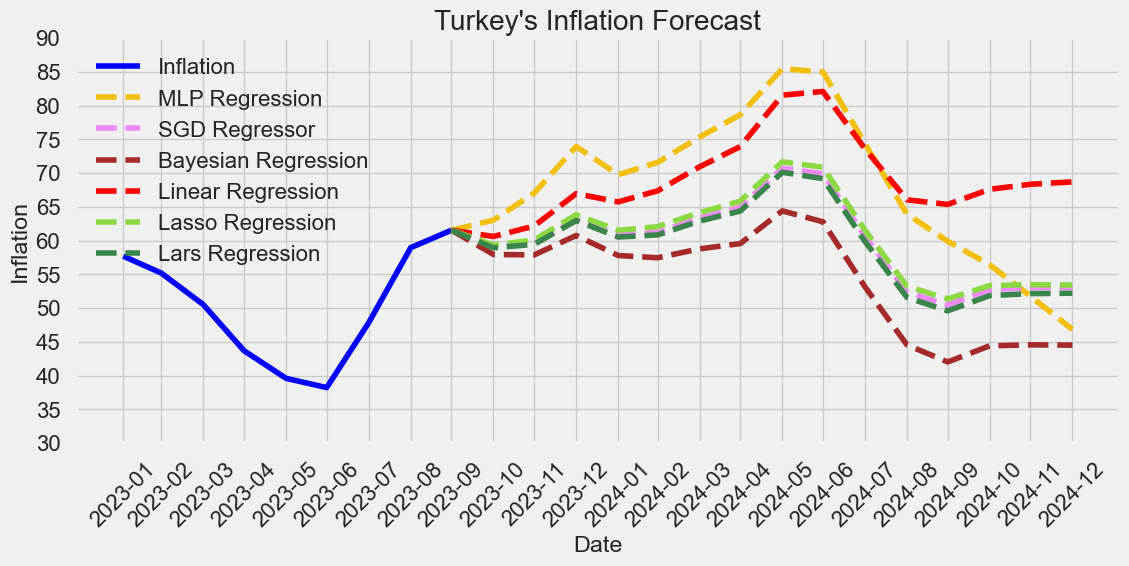

In [281]:








# Grafik çizdirelim
plt.figure(figsize=(12, 5))
plt.plot(df.iloc[191:200,1], label='Inflation', color='blue')
plt.plot(dfas.iloc[199:,0],'--',label=dfas.columns[0], color='#F2BF0D')
plt.plot(dfas.iloc[199:,1],'--',label=dfas.columns[1], color='#EE8AF8')
plt.plot(dfas.iloc[199:,2],'--',label=dfas.columns[2], color='brown')
plt.plot(dfas.iloc[199:,3],'--',label=dfas.columns[3], color='red')
plt.plot(dfas.iloc[199:,5],'--',label=dfas.columns[5], color='#8CD944')
plt.plot(dfas.iloc[199:,6],'--',label=dfas.columns[6], color='#3A854B')
plt.xlabel('Date')
plt.ylabel('Inflation')
plt.xticks(dfas.iloc[191:].index, dfas.iloc[191:].index.strftime('%Y-%m'), rotation=45)
y_max = 100
y_min = 10
y_interval = 0.5
y_ticks = [30]
while y_ticks[-1] < 90:
    y_ticks.append(y_ticks[-1] + 5)









# Y ekseni etiketlerini ayarlama
plt.yticks(y_ticks)
plt.title("Turkey's Inflation Forecast")
plt.legend()
plt.grid(True)
plt.show()


In [261]:
eylül_tahmin=((tüfetahmin.iloc[0,:]/1614)-1)*100
eylül_tahmin

MLP Regression         4.675438
SGD Regressor          3.979506
Bayesian Regression    3.644089
Linear Regression      4.436373
DNN                    4.909488
Lasso Regression       4.056063
Lars Regression        3.951677
Name: 2023-09-30 00:00:00, dtype: float64

In [262]:
aylıktahmin=tüfetahmin.pct_change(periods=1)*100
aylıktahmin=aylıktahmin.dropna(axis=0)
row=pd.DataFrame({eylül_tahmin.index[0]:eylül_tahmin[0],eylül_tahmin.index[1]:eylül_tahmin[1],eylül_tahmin.index[2]:eylül_tahmin[2],eylül_tahmin.index[3]:eylül_tahmin[3],eylül_tahmin.index[4]:eylül_tahmin[4],eylül_tahmin.index[5]:eylül_tahmin[5],eylül_tahmin.index[6]:eylül_tahmin[6]},index=pd.date_range(start="2023-09-30",end="2023-10-29",freq="1M"))
aylıktahmin=pd.concat([row,aylıktahmin],axis=0)
aylıktahmin["Ortalama"]=aylıktahmin.mean(axis=1)
aylıktahmin["Medyan"]=aylıktahmin.median(axis=1)
aylıktahmin

,MLP Regression,SGD Regressor,Bayesian Regression,Linear Regression,DNN,Lasso Regression,Lars Regression,Ortalama,Medyan
2023-09-30,4.675438,3.979506,3.644089,4.436373,4.909488,4.056063,3.951677,4.236091,4.146077
2023-10-31,4.600504,2.716513,2.342732,3.279812,4.029035,2.840614,2.681715,3.212989,3.026801
2023-11-30,5.410583,3.244815,2.839206,3.878479,4.734661,3.366147,3.205141,3.811290,3.588718
2023-12-31,5.357039,3.456846,3.028574,4.176608,4.595030,3.540348,3.425581,3.940004,3.740176
2024-01-31,4.092907,5.098863,4.682790,5.866100,6.067168,5.155480,5.049547,5.144693,5.121778
2024-02-29,4.249649,3.416701,2.928034,4.163692,4.946498,3.485586,3.349822,3.791426,3.638506
2024-03-31,4.529621,3.609551,3.145660,4.464541,4.471126,3.606319,3.590689,3.916787,3.763169
2024-04-30,4.313438,3.398244,2.884046,4.180177,5.031326,3.440279,3.322648,3.795737,3.618008
2024-05-31,3.858720,3.564602,3.085145,4.427705,4.789305,3.562301,3.536289,3.832010,3.698306
2024-06-30,3.667259,3.414812,2.897023,4.231579,4.530735,3.441638,3.345938,3.646998,3.544318


In [263]:
yıllıktahmin=pd.DataFrame(dfas)
yıllıktahmin["Ortalama"]=dfas.mean(axis=1)
yıllıktahmin["Medyan"]=dfas.median(axis=1)
yıllıktahmin.tail(15)

,MLP Regression,SGD Regressor,Bayesian Regression,Linear Regression,DNN,Lasso Regression,Lars Regression,Ortalama,Medyan
2023-10-31,63.024477,59.023850,57.934058,60.598493,62.496340,59.333207,58.927430,60.191122,59.333207
2023-11-30,67.028349,59.581913,57.865659,62.151213,65.419678,60.080260,59.423870,61.650135,60.080260
2023-12-31,73.919208,63.168645,60.745625,66.949153,70.998391,63.810301,62.957789,66.078444,63.810301
2024-01-31,69.750917,60.797085,57.782158,65.723683,70.065587,61.516376,60.513937,63.735678,61.516376
2024-02-29,71.568817,61.220579,57.450192,67.360346,73.035821,62.049632,60.832610,64.788285,62.049632
2024-03-31,75.326176,63.301170,58.768077,70.919059,76.726356,64.135803,62.878538,67.436454,64.135803
2024-04-30,78.627585,64.916446,59.541153,73.915020,81.293269,65.826721,64.369372,69.784224,65.826721
2024-05-31,85.440444,70.721522,64.392415,81.537266,89.894159,71.660023,70.108673,76.250643,71.660023
2024-06-30,84.988552,69.890776,62.773374,82.080688,91.009246,70.869023,69.168169,75.825690,70.869023
2024-07-31,74.356219,60.616997,53.143095,73.590396,84.255792,61.541932,59.869190,66.767660,61.541932


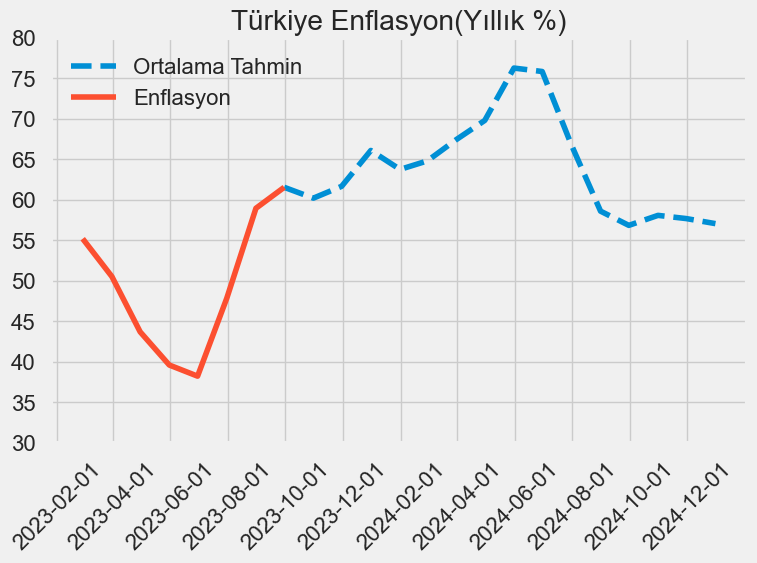

In [264]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8,5))
plt.plot(yıllıktahmin["Ortalama"].tail(16),'--',label="Ortalama Tahmin")
plt.plot(yıllıktahmin["Ortalama"].iloc[-23:-15],label="Enflasyon")
plt.xticks(yıllıktahmin.tail(23).index.strftime("%Y-%m")[::2],rotation=45)
plt.yticks(np.arange(30,85,5))
plt.title("Türkiye Enflasyon(Yıllık %)")
plt.legend()
plt.show()

In [211]:
yıllıktahmin["Ortalama"].tail(15)

2023-10-31    59.788584
2023-11-30    60.918469
2023-12-31    65.020070
2024-01-31    61.714115
2024-02-29    61.887192
2024-03-31    63.573467
2024-04-30    65.905772
2024-05-31    71.422174
2024-06-30    70.202326
2024-07-31    61.285895
2024-08-31    53.297934
2024-09-30    51.455295
2024-10-31    52.538864
2024-11-30    52.177712
2024-12-31    51.805975
Freq: M, Name: Ortalama, dtype: float64

In [132]:
yıllıktahmin.tail(25).index.strftime("%Y-%m")

Index(['2022-09', '2022-10', '2022-11', '2022-12', '2023-01', '2023-02',
       '2023-03', '2023-04', '2023-05', '2023-06', '2023-07', '2023-08',
       '2023-09', '2023-10', '2023-11', '2023-12', '2024-01', '2024-02',
       '2024-03', '2024-04', '2024-05', '2024-06', '2024-07', '2024-08',
       '2024-09'],
      dtype='object')

In [86]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
